# Mini-Batches and DataLoaders

**Task**: Fit a model using SGD (stochastic gradient descent) by using a PyTorch `DataLoader` to generate mini-batches.

**Why**: todo

## Setup

In [1]:
#import torch
#from torch import tensor
#from torch.utils.data import DataLoader
from fastai.vision.all import *
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

In [2]:
if False:
    import pandas as pd
    data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
    data.head()

In [3]:
if False:
    x = torch.tensor(data.iloc[:, 0], dtype=torch.float)
    # scale x to a reasonable range
    x -= 1880.0
    x /= 100.
    y_true = torch.tensor(data.iloc[:, 1], dtype=torch.float)
    plt.plot(x, y_true)

In [4]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=.5, color='#bbbbbb')
def plot_model(x, model):
    x = x.sort(dim=0).values
    y_pred = model(x).detach()
    plt.plot(x[:, 0], y_pred[:, 0], 'r')

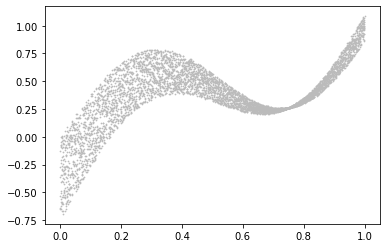

In [52]:
num_points = 5000

set_seed(40)
x = torch.linspace(0, 1, num_points).view((num_points, 1))#torch.rand(num_points, 1)
noise = torch.rand_like(x) * 1.
y_true = .5 * (x*6).sin() + x + (x - .75) * noise

# standardize y, just to make it well behaved.
#y_true -= y_true.mean()
#y_true /= y_true.std()

plot_data(x, y_true)

Create some features that we'll need later; don't worry about this code right now.

In [53]:
offsets = torch.arange(0.0, 1.0, 0.1).view((1, 10))
feats = (x - offsets).clamp_min(0.0)

In [54]:
feats.shape

torch.Size([5000, 10])

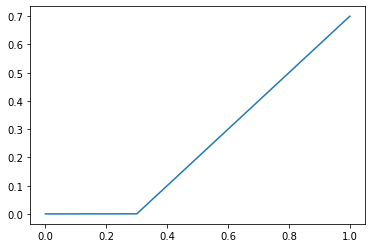

In [55]:
plt.plot(x, feats[:, 3])

In [56]:
set_seed(0)
dataset = list(zip(x, y_true))
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [57]:
for x_batch, y_batch in dataloader:
    print("Got a batch of", len(x_batch), "x samples and", len(y_batch), "y samples")
    break


Got a batch of 100 x samples and 100 y samples


Let's train the simplest possible model on this dataset: we'll try to predict a constant value.

The constant value that minimizes the MSE of the predictions is the *mean* of the whole dataset. Let's see if we get it.

In [58]:
mean_of_whole_dataset = y_true.mean()
mean_of_whole_dataset

tensor(0.3788)

In [59]:
#[y_batch.mean() for x_batch, y_batch in dataloader]

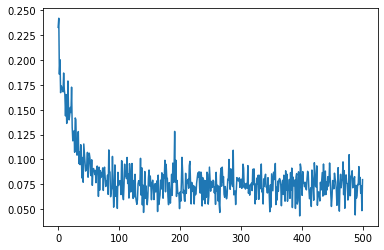

In [60]:
learning_rate = 0.01

# initialize our constant
estimated_constant = torch.tensor(0.0, requires_grad=True)
losses = []

for epoch in range(10):
    for x_batch, y_batch in dataloader:
        # We'll be ignoring x_batch because we're just predicting a constant.
        #print("Got a batch of", len(x_batch), "x samples and", len(y_batch), "y samples")
        loss = (y_batch - estimated_constant).pow(2).mean()
        losses.append(loss.item())
        loss.backward()
        estimated_constant.data -= learning_rate * estimated_constant.grad
        estimated_constant.grad.zero_()

plt.plot(losses)

In [61]:
estimated_constant

tensor(0.3785, requires_grad=True)

Now, let's go back to your linear-regression-from-scratch notebook and make it use mini-batches. We'll start with a working training loop:

Final MSE: 0.051


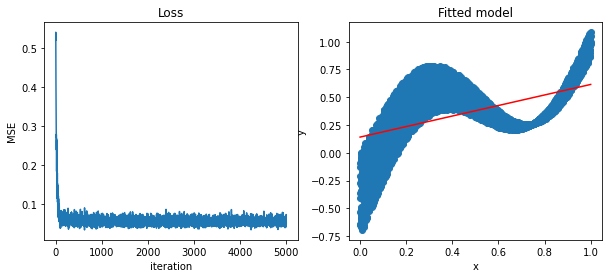

In [62]:
# Set hyperparameters
learning_rate = .01
num_iter = 50

weights = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

losses = []

for epoch in range(100):
    for x_batch, y_batch in dataloader:
        # Forward pass:
        y_pred = x_batch @ weights + bias
        resid = y_batch - y_pred.view((-1, 1))
        loss = resid.pow(2).mean()
        losses.append(loss.item())

        # Backward pass:
        loss.backward()
        
        # Descend the gradient.
        weights.data -= learning_rate * weights.grad
        bias.data -= learning_rate * bias.grad
        #print(weights.data, weights.grad)
        # Clear out the gradient data for next time.
        weights.grad.zero_()
        bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, (x @ weights + bias).detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {losses[-1]:.3f}")

torch.Size([100, 100])

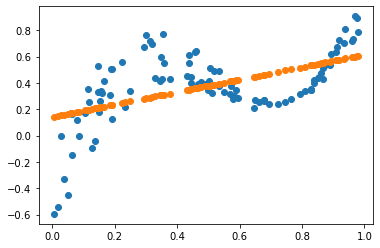

In [63]:
weights.grad.zero_()
bias.grad.zero_()
y_pred = x_batch @ weights + bias
resid = y_batch - y_pred
resid.retain_grad()
loss = resid.pow(2).mean()
losses.append(loss.item())

# Backward pass:
loss.backward()

plt.scatter(x_batch, y_batch)
plt.scatter(x_batch, y_pred.detach())
#plt.scatter(x_batch, resid.grad)
resid.grad.shape

In [41]:
y_batch.shape

torch.Size([100, 1])

In [46]:
y_pred.shape

torch.Size([100])

In [28]:
x_batch.shape, weights.shape, bias.shape

(torch.Size([100, 1]), torch.Size([1]), torch.Size([1]))

In [31]:
(x_batch @ weights + bias).shape

torch.Size([100])

In [21]:
weights

tensor([-0.2218], requires_grad=True)

Final MSE: 0.042


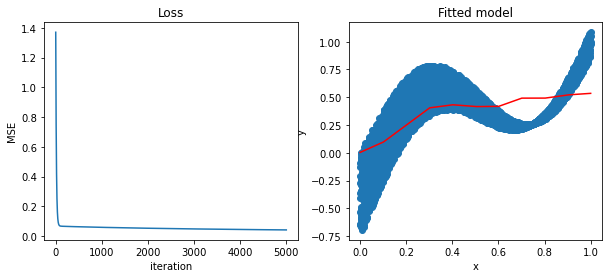

In [66]:
# remove
weights = torch.randn(10, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

losses = []

for epoch in range(5000):
    # Forward pass:
    y_pred = feats @ weights + bias
    resid = y_true - y_pred.view((-1, 1))
    loss = resid.pow(2).mean()
    losses.append(loss.item())

    # Backward pass:
    loss.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {losses[-1]:.3f}")

In [102]:
feats.shape

torch.Size([5000, 10])

In [103]:
weights.shape

torch.Size([2])